## How the *S* tensor behaves



In [2]:
# load modules 

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
from matplotlib import colors, ticker, cm
from matplotlib.colors import LogNorm
%matplotlib inline
from funcs import *
import os 
from xgcm import Grid

In [3]:
params = {
   'axes.labelsize': 12,
   'font.size': 12,
   'legend.fontsize': 12,
   'xtick.labelsize': 12,
   'ytick.labelsize': 12,
   'text.usetex': False,
   'figure.figsize': [4.5, 4.5]
   }
plt.rcParams.update(params)

In [4]:
Lcoarse = 50e3

In [5]:
Model_Tav = xr.open_dataset('./outputs_ncfiles/Model_Tav.nc')

In [6]:
diff_tensor = xr.open_dataset('./outputs_ncfiles/diff_tensor_'+str(int(Lcoarse//1e3))+'km.nc')
Trac_coarse = xr.open_dataset('./outputs_ncfiles/Trac_coarse_'+str(int(Lcoarse//1e3))+'km.nc')
Vels_coarse = xr.open_dataset('./outputs_ncfiles/Vels_coarse_'+str(int(Lcoarse//1e3))+'km.nc')
T_coarse    = xr.open_dataset('./outputs_ncfiles/T_coarse_'+str(int(Lcoarse//1e3))+'km.nc')

In [7]:
fluxT = xr.Dataset({'UpCp':T_coarse.UpTp, 'VpCp':T_coarse.VpTp, 'WpCp':T_coarse.WpTp})
gradT = xr.Dataset({'dCdx':T_coarse.T_X, 'dCdy':T_coarse.T_Y, 'dCdz':T_coarse.T_Z})

In [8]:
def flux_reconstruct(tensor, flux, grads):

    recUflux = -(tensor.sel(i=0, j=0)*grads.dCdx + tensor.sel(i=0, j=1)*grads.dCdy + tensor.sel(i=0, j=2)*grads.dCdz)
    recVflux = -(tensor.sel(i=1, j=0)*grads.dCdx + tensor.sel(i=1, j=1)*grads.dCdy + tensor.sel(i=1, j=2)*grads.dCdz)
    recWflux = -(tensor.sel(i=2, j=0)*grads.dCdx + tensor.sel(i=2, j=1)*grads.dCdy + tensor.sel(i=2, j=2)*grads.dCdz)

    errU = np.abs(flux.UpCp - recUflux)/np.abs(flux.UpCp)
    errV = np.abs(flux.VpCp - recVflux)/np.abs(flux.VpCp)
    errW = np.abs(flux.WpCp - recWflux)/np.abs(flux.WpCp)
    
    flux_rec=xr.Dataset({'UpCp':recUflux, 'VpCp':recVflux, 'WpCp':recWflux,
                                'errU':errU, 'errV':errV, 'errW':errW})
    
    return flux_rec

In [9]:
frb = flux_reconstruct(diff_tensor.Kcorr, fluxT, gradT)
frb_AT = flux_reconstruct(diff_tensor.ATcorr, fluxT, gradT) 
frb_ST = flux_reconstruct(diff_tensor.STcorr, fluxT, gradT) 

ST is important everywhere.
Even in upstream region the buoyancy flux reconstructed from A is not the dominant component of the buoyancy flux.

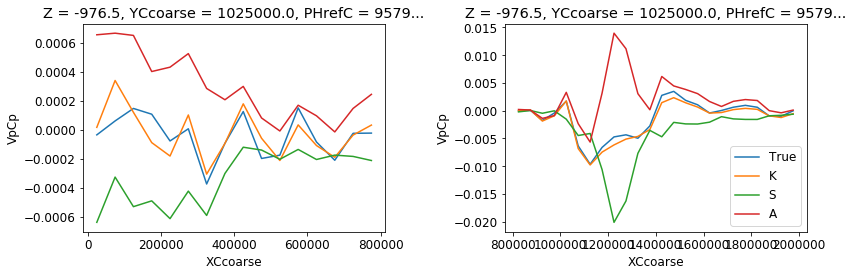

In [20]:

plt.figure(figsize=(12,4))

plt.subplot(121)
fluxT.VpCp.sel(Z=-1000, YCcoarse=1000e3, method='nearest').sel(XCcoarse=slice(0,800e3)).plot(label='True')
frb.VpCp.sel(Z=-1000, YCcoarse=1000e3, method='nearest').sel(XCcoarse=slice(0,800e3)).plot(label='K')
frb_AT.VpCp.sel(Z=-1000, YCcoarse=1000e3, method='nearest').sel(XCcoarse=slice(0,800e3)).plot(label='S')
frb_ST.VpCp.sel(Z=-1000, YCcoarse=1000e3, method='nearest').sel(XCcoarse=slice(0,800e3)).plot(label='A')

plt.subplot(122)
fluxT.VpCp.sel(Z=-1000, YCcoarse=1000e3, method='nearest').sel(XCcoarse=slice(800e3,2000e3)).plot(label='True')
frb.VpCp.sel(Z=-1000, YCcoarse=1000e3, method='nearest').sel(XCcoarse=slice(800e3,2000e3)).plot(label='K')
frb_AT.VpCp.sel(Z=-1000, YCcoarse=1000e3, method='nearest').sel(XCcoarse=slice(800e3,2000e3)).plot(label='S')
frb_ST.VpCp.sel(Z=-1000, YCcoarse=1000e3, method='nearest').sel(XCcoarse=slice(800e3,2000e3)).plot(label='A')
plt.legend()

plt.tight_layout()

Break up F_s into a parallel and perp part.

In [10]:
gradbmod = (T_coarse.T_X**2 + T_coarse.T_Y**2 + T_coarse.T_Z**2)**0.5

In [11]:
Fb_perp_mod = (fluxT.UpCp*T_coarse.T_X + fluxT.VpCp*T_coarse.T_Y + fluxT.WpCp*T_coarse.T_Z) / gradbmod
Fb_perp_x = Fb_perp_mod*T_coarse.T_X / gradbmod
Fb_perp_y = Fb_perp_mod*T_coarse.T_Y / gradbmod
Fb_perp_z = Fb_perp_mod*T_coarse.T_Z / gradbmod

Fb_para_x = fluxT.UpCp - Fb_perp_x
Fb_para_y = fluxT.VpCp - Fb_perp_y
Fb_para_z = fluxT.WpCp - Fb_perp_z

In [12]:
Frb_perp_mod = (frb.UpCp*T_coarse.T_X + frb.VpCp*T_coarse.T_Y + frb.WpCp*T_coarse.T_Z) / gradbmod
Frb_perp_x = Frb_perp_mod*T_coarse.T_X / gradbmod
Frb_perp_y = Frb_perp_mod*T_coarse.T_Y / gradbmod
Frb_perp_z = Frb_perp_mod*T_coarse.T_Z / gradbmod

Frb_para_x = frb.UpCp - Frb_perp_x
Frb_para_y = frb.VpCp - Frb_perp_y
Frb_para_z = frb.WpCp - Frb_perp_z

In [13]:
Frb_AT_perp_mod = (frb_AT.UpCp*T_coarse.T_X + frb_AT.VpCp*T_coarse.T_Y + frb_AT.WpCp*T_coarse.T_Z) / gradbmod
Frb_AT_perp_x = Frb_AT_perp_mod*T_coarse.T_X / gradbmod
Frb_AT_perp_y = Frb_AT_perp_mod*T_coarse.T_Y / gradbmod
Frb_AT_perp_z = Frb_AT_perp_mod*T_coarse.T_Z / gradbmod

Frb_AT_para_x = frb_AT.UpCp - Frb_AT_perp_x
Frb_AT_para_y = frb_AT.VpCp - Frb_AT_perp_y
Frb_AT_para_z = frb_AT.WpCp - Frb_AT_perp_z

In [14]:
Frb_ST_perp_mod = (frb_ST.UpCp*T_coarse.T_X + frb_ST.VpCp*T_coarse.T_Y + frb_ST.WpCp*T_coarse.T_Z) / gradbmod
Frb_ST_perp_x = Frb_ST_perp_mod*T_coarse.T_X / gradbmod
Frb_ST_perp_y = Frb_ST_perp_mod*T_coarse.T_Y / gradbmod
Frb_ST_perp_z = Frb_ST_perp_mod*T_coarse.T_Z / gradbmod

Frb_ST_para_x = frb_ST.UpCp - Frb_ST_perp_x
Frb_ST_para_y = frb_ST.VpCp - Frb_ST_perp_y
Frb_ST_para_z = frb_ST.WpCp - Frb_ST_perp_z

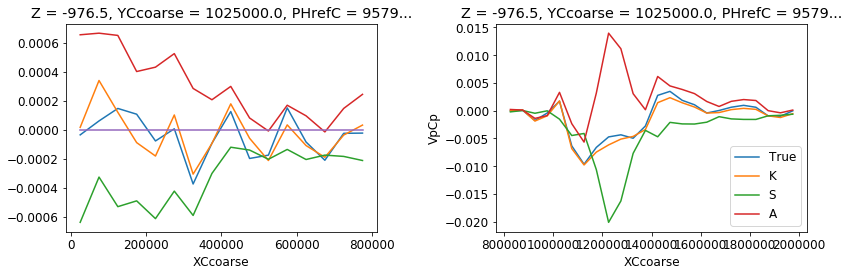

In [15]:

plt.figure(figsize=(12,4))

plt.subplot(121)
Fb_para_y.sel(Z=-1000, YCcoarse=1000e3, method='nearest').sel(XCcoarse=slice(0,800e3)).plot(label='True')
Frb_para_y.sel(Z=-1000, YCcoarse=1000e3, method='nearest').sel(XCcoarse=slice(0,800e3)).plot(label='K')
Frb_AT_para_y.sel(Z=-1000, YCcoarse=1000e3, method='nearest').sel(XCcoarse=slice(0,800e3)).plot(label='S')
Frb_ST_para_y.sel(Z=-1000, YCcoarse=1000e3, method='nearest').sel(XCcoarse=slice(0,800e3)).plot(label='A')
Frb_ST_perp_y.sel(Z=-1000, YCcoarse=1000e3, method='nearest').sel(XCcoarse=slice(0,800e3)).plot(label='A')

plt.subplot(122)
fluxT.VpCp.sel(Z=-1000, YCcoarse=1000e3, method='nearest').sel(XCcoarse=slice(800e3,2000e3)).plot(label='True')
frb.VpCp.sel(Z=-1000, YCcoarse=1000e3, method='nearest').sel(XCcoarse=slice(800e3,2000e3)).plot(label='K')
frb_AT.VpCp.sel(Z=-1000, YCcoarse=1000e3, method='nearest').sel(XCcoarse=slice(800e3,2000e3)).plot(label='S')
frb_ST.VpCp.sel(Z=-1000, YCcoarse=1000e3, method='nearest').sel(XCcoarse=slice(800e3,2000e3)).plot(label='A')
plt.legend()

plt.tight_layout()

Obviously Fsperp is tiny compared to Fspara 

### Rotated buoyancy gradient 

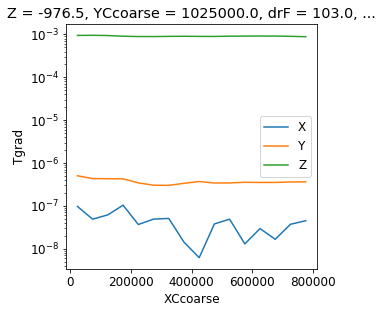

In [48]:
np.abs(T_coarse.T_X).sel(Z=-1000, YCcoarse=1000e3, method='nearest').sel(XCcoarse=slice(0,800e3)).plot(label='X')
np.abs(T_coarse.T_Y).sel(Z=-1000, YCcoarse=1000e3, method='nearest').sel(XCcoarse=slice(0,800e3)).plot(label='Y')
np.abs(T_coarse.T_Z).sel(Z=-1000, YCcoarse=1000e3, method='nearest').sel(XCcoarse=slice(0,800e3)).plot(label='Z')
plt.yscale('log')

plt.ylabel('Tgrad')
plt.legend()

In [16]:
print(diff_tensor.eigvecsSTcorr.sel(XCcoarse=0, YCcoarse=1000e3, Z=-1000, method='nearest'))
print(diff_tensor.eigvalsSTcorr.sel(XCcoarse=0, YCcoarse=1000e3, Z=-1000, method='nearest'))

<xarray.DataArray 'eigvecsSTcorr' (k: 3, ii: 3)>
array([[ 1.588807e-04, -1.861261e-01,  9.825258e-01],
       [ 7.162975e-04, -9.825256e-01, -1.861262e-01],
       [ 9.999998e-01,  7.333527e-04, -2.278271e-05]], dtype=float32)
Coordinates:
    Z            float32 -976.5
    YCcoarse     float32 1025000.0
    XCcoarse     float32 25000.0
    hFacCcoarse  float32 ...
    PHrefC       float32 ...
    drF          float32 ...
Dimensions without coordinates: k, ii
<xarray.DataArray 'eigvalsSTcorr' (ii: 3)>
array([9.765625e-04, 3.806697e+03, 8.241475e+03], dtype=float32)
Coordinates:
    Z            float32 -976.5
    YCcoarse     float32 1025000.0
    XCcoarse     float32 25000.0
    hFacCcoarse  float32 ...
    PHrefC       float32 ...
    drF          float32 ...
Dimensions without coordinates: ii


In [44]:
diff_tensor.eigvecsSTcorr.sel(XCcoarse=0, YCcoarse=1000e3, Z=-1000, method='nearest').sel(ii=0)

<xarray.DataArray 'eigvecsSTcorr' (k: 3)>
array([1.588807e-04, 7.162975e-04, 9.999998e-01], dtype=float32)
Coordinates:
    Z            float32 -976.5
    YCcoarse     float32 1025000.0
    XCcoarse     float32 25000.0
    hFacCcoarse  float32 ...
    PHrefC       float32 ...
    drF          float32 ...
Dimensions without coordinates: k

In [17]:
gradb2 = T_coarse.T_X**2 + T_coarse.T_Y**2 + T_coarse.T_Z**2

In [18]:
db1 = diff_tensor.eigvecsSTcorr.isel(ii=0, k=0)*T_coarse.T_X + diff_tensor.eigvecsSTcorr.isel(ii=0, k=1)*T_coarse.T_Y + diff_tensor.eigvecsSTcorr.isel(ii=0, k=2)*T_coarse.T_Z
db2 = diff_tensor.eigvecsSTcorr.isel(ii=1, k=0)*T_coarse.T_X + diff_tensor.eigvecsSTcorr.isel(ii=1, k=1)*T_coarse.T_Y + diff_tensor.eigvecsSTcorr.isel(ii=1, k=2)*T_coarse.T_Z
db3 = diff_tensor.eigvecsSTcorr.isel(ii=2, k=0)*T_coarse.T_X + diff_tensor.eigvecsSTcorr.isel(ii=2, k=1)*T_coarse.T_Y + diff_tensor.eigvecsSTcorr.isel(ii=2, k=2)*T_coarse.T_Z

In [20]:
# we can use cosine to calculate the angle but it does a pretty terrible job 
cosgamma = db1 / gradb2**0.5
gamma = np.arccos(cosgamma)*180/np.pi


/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/xarray/core/computation.py:603: RuntimeWarning: invalid value encountered in arccos
  result_data = func(*input_data)


In [21]:
evx =  diff_tensor.eigvecsSTcorr.isel(ii=0, k=0)
evy =  diff_tensor.eigvecsSTcorr.isel(ii=0, k=1)
evz =  diff_tensor.eigvecsSTcorr.isel(ii=0, k=2)
dTx = T_coarse.T_X
dTy = T_coarse.T_Y
dTz = T_coarse.T_Z

In [22]:
crossprod = ((evy*dTz - evz*dTy)**2 + (evz*dTx - evx*dTz)**2 + (evx*dTy - evy*dTx)**2)**0.5

In [23]:
singamma = crossprod/ gradb2**0.5

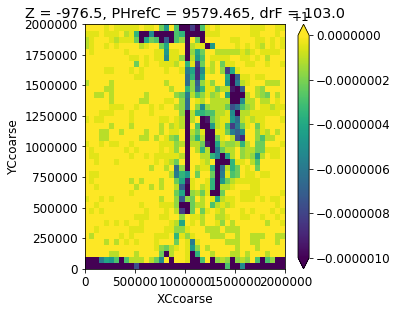

In [24]:
cosgamma.sel(Z=-1000, method='nearest').plot(vmin=.999999, vmax =1)

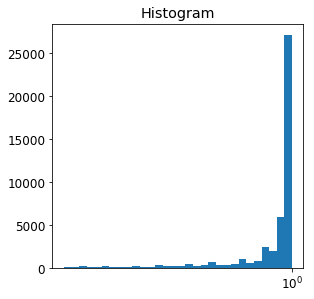

In [240]:
[_,_,_] = cosgamma.plot.hist(bins=np.logspace(-0.000001, 0, 31))
plt.xscale('log')

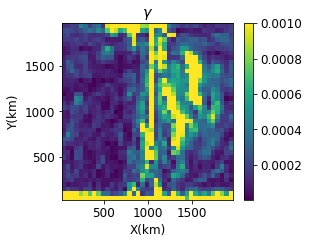

In [41]:
plt.figure(figsize=(4.4,3.55))
plt.pcolormesh(singamma.XCcoarse/1e3, singamma.YCcoarse/1e3,  
               singamma.sel(Z=-1000, method='nearest'), vmax=1e-3)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')
h= plt.colorbar()
plt.title('$\gamma$')
plt.tight_layout()
plt.savefig('gamma.pdf')

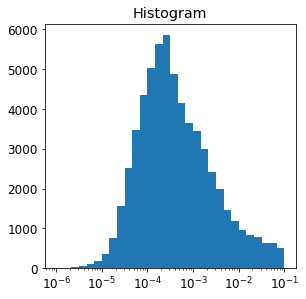

In [234]:
[_,_,_] = singamma.plot.hist(bins=np.logspace(-6, -1, 31))
plt.xscale('log')

In [1]:
np.log(cosgamma).sel(Z=-1000, method='nearest').plot(vmin=-0.000001)

NameError: name 'np' is not defined

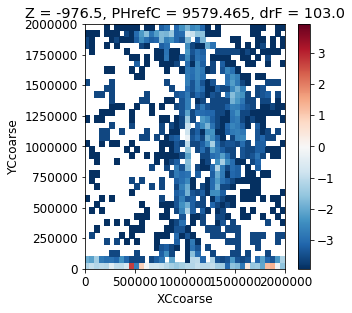

In [211]:
np.log(gamma).sel(Z=-1000, method='nearest').plot()

In [85]:
horbit1 = diff_tensor.eigvalsSTcorr.isel(ii=1) * db2**2/gradb2
horbit2 = diff_tensor.eigvalsSTcorr.isel(ii=2) * db3**2/gradb2
verbit  = diff_tensor.eigvalsSTcorr.isel(ii=0) * db1**2/gradb2 

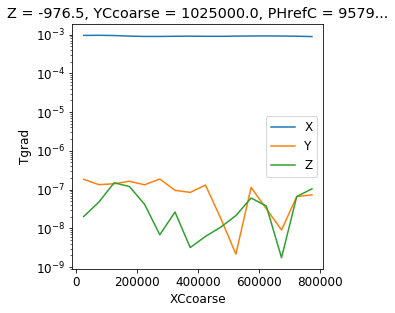

In [47]:
np.abs(db1).sel(Z=-1000, YCcoarse=1000e3, method='nearest').sel(XCcoarse=slice(0,800e3)).plot(label='X')
np.abs(db2).sel(Z=-1000, YCcoarse=1000e3, method='nearest').sel(XCcoarse=slice(0,800e3)).plot(label='Y')
np.abs(db3).sel(Z=-1000, YCcoarse=1000e3, method='nearest').sel(XCcoarse=slice(0,800e3)).plot(label='Z')
plt.yscale('log')

plt.ylabel('Tgrad')
plt.legend()

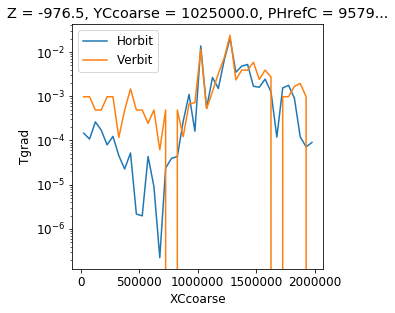

In [86]:
np.abs(horbit1 + horbit2).sel(Z=-1000, YCcoarse=1000e3, method='nearest').sel(XCcoarse=slice(0,2000e3)).plot(label='Horbit')
np.abs(verbit).sel(Z=-1000, YCcoarse=1000e3, method='nearest').sel(XCcoarse=slice(0,2000e3)).plot(label='Verbit')
#p.abs(db3).sel(Z=-1000, YCcoarse=1000e3, method='nearest').sel(XCcoarse=slice(0,800e3)).plot(label='Z')
plt.yscale('log')

plt.ylabel('Tgrad')
plt.legend()

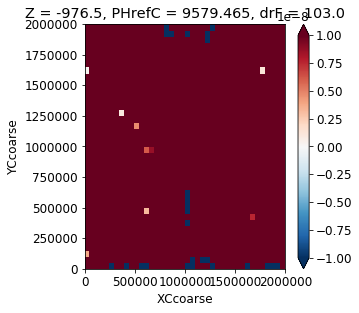

In [87]:
horbit1.sel(Z=-1000, method='nearest').plot(vmin=-1e-8, label='Horbit')

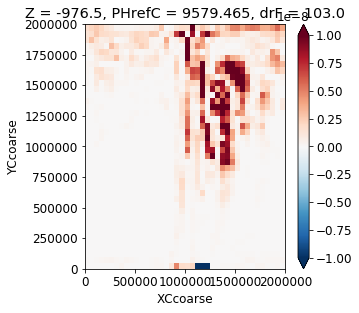

In [70]:
horbit2.sel(Z=-1000, method='nearest').plot(vmin=-1e-8, label='Horbit')

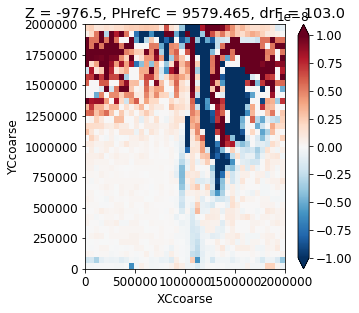

In [66]:
verbit.sel(Z=-1000, method='nearest').plot(vmin=-1e-8, label='Horbit')

In [100]:
from xhistogram.xarray import histogram

In [121]:
bins = np.logspace(-8, 3, 21)

In [122]:
binslog = np.concatenate((-bins[-1::-1], bins))

In [123]:
binslog

array([-1.00000000e+03, -2.81838293e+02, -7.94328235e+01, -2.23872114e+01,
       -6.30957344e+00, -1.77827941e+00, -5.01187234e-01, -1.41253754e-01,
       -3.98107171e-02, -1.12201845e-02, -3.16227766e-03, -8.91250938e-04,
       -2.51188643e-04, -7.07945784e-05, -1.99526231e-05, -5.62341325e-06,
       -1.58489319e-06, -4.46683592e-07, -1.25892541e-07, -3.54813389e-08,
       -1.00000000e-08,  1.00000000e-08,  3.54813389e-08,  1.25892541e-07,
        4.46683592e-07,  1.58489319e-06,  5.62341325e-06,  1.99526231e-05,
        7.07945784e-05,  2.51188643e-04,  8.91250938e-04,  3.16227766e-03,
        1.12201845e-02,  3.98107171e-02,  1.41253754e-01,  5.01187234e-01,
        1.77827941e+00,  6.30957344e+00,  2.23872114e+01,  7.94328235e+01,
        2.81838293e+02,  1.00000000e+03])

Text(0.5, 1.0, 'Horizontal Bit')

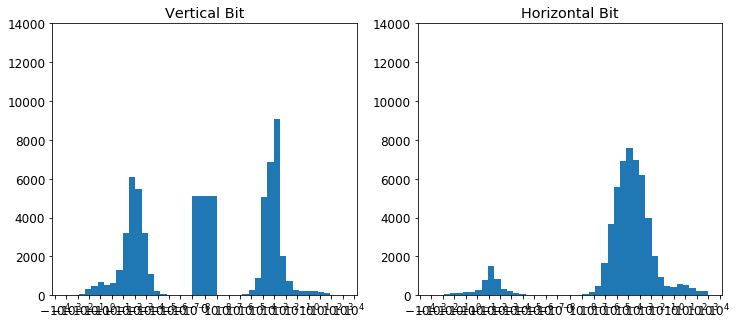

In [130]:
plt.figure(figsize=(12,5))
plt.subplot(121)
[_,_,_] = verbit.where(T_coarse.hFacCcoarse==1.).sel(YCcoarse=slice(0, 1800e3)).plot.hist(bins = binslog)
plt.xscale('symlog', linthreshx=1e-8)
plt.ylim([0,14000])
plt.title('Vertical Bit')

plt.subplot(122)
[_,_,_] = (horbit1 + horbit2).where(T_coarse.hFacCcoarse==1.).sel(YCcoarse=slice(0, 1800e3)).plot.hist(bins = binslog)
plt.xscale('symlog', linthreshx=1e-8)
plt.ylim([0,14000])
plt.title('Horizontal Bit')

In [153]:
XY = T_coarse.T*0. + 1
XY

<xarray.DataArray 'T' (Z: 40, YCcoarse: 40, XCcoarse: 40)>
array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       ...,

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1.,

In [163]:
weights = T_coarse.drF *XY/3000

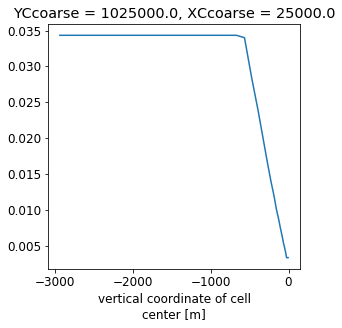

In [164]:
weights.sel(XCcoarse=0, YCcoarse=1000e3, method='nearest').plot()

In [184]:
h = histogram((horbit1+horbit2).where(T_coarse.hFacCcoarse==1.).sel(YCcoarse=slice(0, 1800e3)).rename('horbit'), 
              verbit.where(T_coarse.hFacCcoarse==1.).sel(YCcoarse=slice(0, 1800e3)).rename('verbit'), 
              bins = [binslog, binslog], 
              weights = weights.where(T_coarse.hFacCcoarse==1.).sel(YCcoarse=slice(0, 1800e3)))

In [188]:
hUS = histogram((horbit1+horbit2).where(T_coarse.hFacCcoarse==1.).sel(XCcoarse=slice(400e3,800e3), YCcoarse=slice(0, 1800e3)).rename('horbit'), 
              verbit.where(T_coarse.hFacCcoarse==1.).sel(XCcoarse=slice(400e3,800e3), YCcoarse=slice(0, 1800e3)).rename('verbit'), 
              bins = [binslog, binslog], 
              weights = weights.where(T_coarse.hFacCcoarse==1.).sel(XCcoarse=slice(400e3,800e3), YCcoarse=slice(0, 1800e3)))

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/xarray/core/computation.py:603: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


(-10000.0, 10000.0)

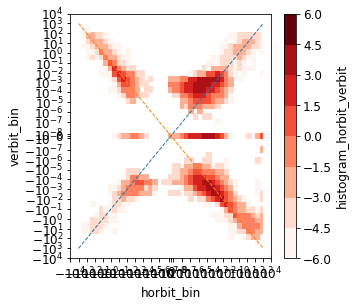

In [185]:
np.log(h).T.plot(levels=11, cmap='Reds')
plt.plot(binslog, binslog, linestyle='--', linewidth=1)
plt.plot(binslog, -binslog, linestyle='--', linewidth=1)
plt.xscale('symlog', linthreshx=5e-8)
plt.yscale('symlog', linthreshy=5e-8)
plt.xlim([-1e4, 1e4])
plt.ylim([-1e4, 1e4])

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/xarray/core/computation.py:603: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


(-10000.0, 10000.0)

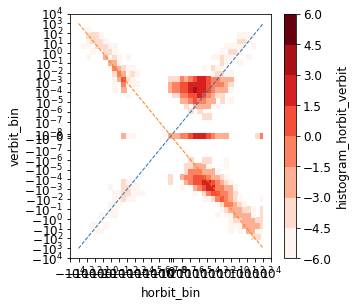

In [189]:
np.log(hUS).T.plot(levels=11, cmap='Reds')
plt.plot(binslog, binslog, linestyle='--', linewidth=1)
plt.plot(binslog, -binslog, linestyle='--', linewidth=1)
plt.xscale('symlog', linthreshx=5e-8)
plt.yscale('symlog', linthreshy=5e-8)
plt.xlim([-1e4, 1e4])
plt.ylim([-1e4, 1e4])

(-10000.0, 10000.0)

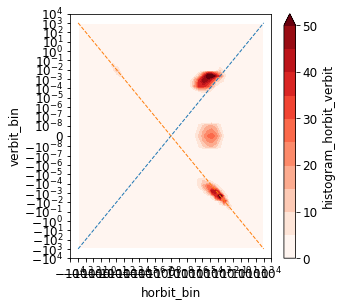

In [175]:
h.T.plot.contourf(levels=11, cmap='Reds', vmax=50)
plt.plot(binslog, binslog, linestyle='--', linewidth=1)
plt.plot(binslog, -binslog, linestyle='--', linewidth=1)
plt.xscale('symlog', linthreshx=1e-8)
plt.yscale('symlog', linthreshy=1e-8)
plt.xlim([-1e4, 1e4])
plt.ylim([-1e4, 1e4])


(-10000.0, 10000.0)

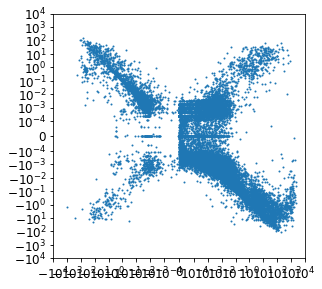

In [99]:
plt.scatter((horbit1+horbit2).sel(YCcoarse=slice(0, 1800e3), Z=slice(0,-800)), verbit.sel(YCcoarse=slice(0, 1800e3), Z=slice(0,-800)), s=1)
plt.xscale('symlog', linthreshx=1e-4)
plt.yscale('symlog', linthreshy=1e-4)
plt.xlim([-1e4, 1e4])
plt.ylim([-1e4, 1e4])

(-1000.0, 1000.0)

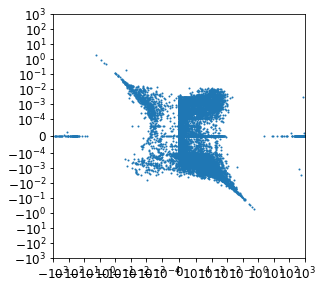

In [97]:
plt.scatter((horbit1+horbit2).sel(YCcoarse=slice(0, 1800e3), Z=slice(-800,-3000)), verbit.sel(YCcoarse=slice(0, 1800e3), Z=slice(-800,-3000)), s=1)
plt.xscale('symlog', linthreshx=1e-4)
plt.yscale('symlog', linthreshy=1e-4)
plt.xlim([-1e3, 1e3])
plt.ylim([-1e3, 1e3])